In [ ]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Load the dataset
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

In [ ]:
# Preprocess the text
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

In [ ]:
# Apply the preprocessing function to the 'headline' column
data['headline'] = data['headline'].apply(preprocess_text)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['headline'], data['is_sarcastic'], test_size=0.3, random_state=42)

In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Pad sequences
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [ ]:
# Build the model
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# Train the model with early stopping
history = model.fit(X_train_pad, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
468/468 [==============================] - 382s 794ms/step - loss: 0.4318 - accuracy: 0.7874 - val_loss: 0.3485 - val_accuracy: 0.8471
Epoch 2/100
468/468 [==============================] - 335s 717ms/step - loss: 0.1681 - accuracy: 0.9390 - val_loss: 0.4077 - val_accuracy: 0.8380
Epoch 3/100
468/468 [==============================] - 333s 711ms/step - loss: 0.0546 - accuracy: 0.9821 - val_loss: 0.5799 - val_accuracy: 0.8334
Epoch 4/100
468/468 [==============================] - 323s 691ms/step - loss: 0.0289 - accuracy: 0.9908 - val_loss: 0.7095 - val_accuracy: 0.8262


In [ ]:
# Evaluate the model
y_pred_prob = model.predict(X_test_pad)
y_pred = np.round(y_pred_prob).astype(int)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('F1-score:', f1)

251/251 [==============================] - 48s 184ms/step
Accuracy: 0.8588543616622988
F1-score: 0.8414411888406


Text(0.5, 1.0, 'Training and Validation Accuracy')

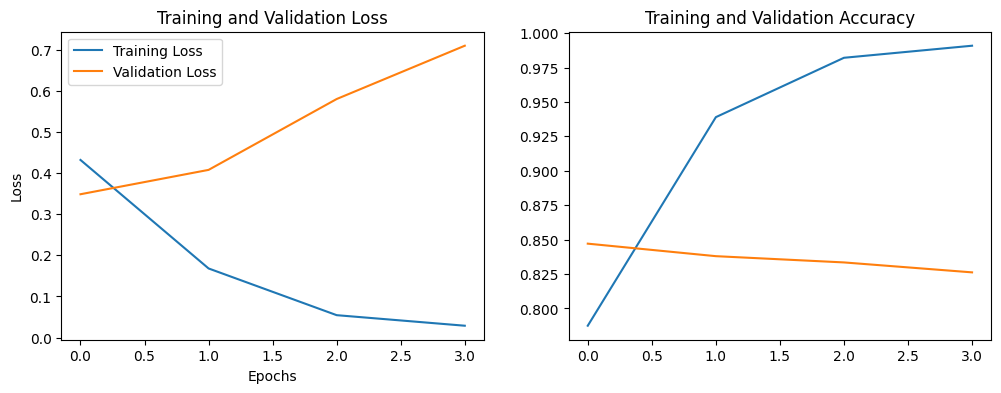

In [ ]:
# Plot the learning curves
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()